# Regresión logística

## Introducción

El objetivo de este archivo es mostrar el desarrollo de regresión logística en el marco de machine learning y el modelo lineal general.

Cuando hablamos de regresión logística nos referimos a una tarea de predicción de una variable con múltiples categorías, lo cual es conocido como un problema de clasificación. En particular en este libro de notas nos restringiremos a la regresión logística binaria, en la que los posibles resultados de la variable predictora son solo dos, y se puede pensar en que la respuesta es una variable binomial.

##Data and business understanding

Trabajaremos con el contexto del archivo de cartera de empresas. Para mantener los libros de nota modulares, repetiré aquí el contexto:

In [ ]:
if (!require('caret')) install.packages('caret')
if (!require('ROCR')) install.packages('ROCR')

Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ROCR

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ROCR’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’




In [ ]:
library(caret)
library(ROCR)
library(ggplot2)
library(readxl)

Loading required package: ggplot2

Loading required package: lattice



In [ ]:
cartera<-read_excel("carteraguia2017.xlsx")
str(cartera)

tibble [852 × 9] (S3: tbl_df/tbl/data.frame)
 $ MESES                   : num [1:852] 41 27 40 41 24 41 39 43 24 36 ...
 $ TIPO_ips                : num [1:852] 3 1 1 1 2 2 1 1 1 1 ...
 $ IGUAL_DUENO             : num [1:852] 17 10 15 15 2 5 20 12 3 0 ...
 $ AGNOS_DIRECCION_ACTUAL  : num [1:852] 12 6 14 14 0 5 9 11 4 13 ...
 $ VENTAS_MENS_PROMEDIO    : num [1:852] 176 31 55 120 28 25 67 38 19 25 ...
 $ PORC_PASIVOS_VENTA_ANUAL: num [1:852] 9.3 17.3 5.5 2.9 17.3 10.2 30.6 3.6 24.4 19.7 ...
 $ cartera_actual_insumos_A: num [1:852] 11.359 1.362 0.856 2.659 1.787 ...
 $ cartera_actual_insumos_B: num [1:852] 5.009 4.001 2.169 0.821 3.057 ...
 $ retrasos                : num [1:852] 1 0 0 0 1 0 0 0 1 0 ...


El archivo contiene datos de clientes de un proveedor de instituciones de salud (IPS), la cartera que presentan y si se han retrasado o no. Se trata entonces de un negocio B2B en el sector de la salud que desea predecir o averiguar indicadores de posibles aumentos y retrasos en su cartera

Entre las variables predictoras se incluyen:


*   Tipo_IPS: De 1 a5, el nivel de complejidad de la institución de salud cliente (1=bajo, 5=alto)

*   MESES: Los meses que la empresa lleva siendo clientes del proveedor.

*   IGUAL_DUEÑO: Número de años en que la IPS ha tenido el mismo dueño.

*   AGNOS_DIRECCION_ACTUAL: Número de años en que la IPS ha estado en la misma dirección.

*   VENTAS_MENS_PROMEDIO: Valor de ventas mensuales promedio de la IPS en millones de pesos.

*   PORC_PASIVOS_VENTA_ANUAL: Porcentaje de pasivos/ venta anual del último balance disponible.


*   CARTERA_ACTUAL_INSUMOS_A: Valor de la deuda con el proveedor en insumos de alta rotación (gasa, jeringas, por ejemplo) en millones de pesos.

*   CARTERA_ACTUAL_INSUMOS_B: Valor de la deuda con el proveedor en insumos de baja rotación (equipos, instrumentos, por ejemplo) en millones de pesos.



La variable a predecir son los RETRASOS, que indican sí el cliente se ha retrasado o no, siendo 1=sí y 0=No.

##Data preparation

Primero vamos a convertir a factores las dos variables que lo requieren: Tipo IPS y retrasos. También vamos a crear variables binarias para los tipos de IPS y luego retirar la variable TIPO IPS.

In [ ]:
cartera$TIPOips<-as.factor(cartera$TIPO_ips)
cartera$retrasos<-as.factor(cartera$retrasos)

In [ ]:
#carterawin<-dummyVars("~.",data=cartera)
#carterafin<-as.data.frame(predict(carterawin,newdata=cartera))
#carterafin2<-within(carterafin,rm(TIPOips.5,TIPO_ips))
#carterafin2$retrasos<-as.factor(carterafin2$retrasos)

Si se desea se puede realizar una exploración básica de las variables independientes antes de separarlas en bases de entrenamiento y validación, lo que se deja al lector.

De todos modos, es importante ver la proporción de retrasos vs. no retrasos. En caso de que una de las clases, usualmente la clase que más interesa predecir, tenga un porcentaje mucho menor que la otra (digamos, menos del 20%) es necesario un balanceo de la base de datos.

In [ ]:
balance<-table(cartera$retrasos)
prop.table(balance)


        0         1 
0.7734742 0.2265258 

Incialmente no es necesario un balanceo, pero podemos considerarlo más adelante si queremos que el algoritmo “aprenda” más sobre los retrasos.

Creemos bases de entrenamiento y validación

In [ ]:
set.seed(1)
#aquí se define el tamaño de la muestra, en este caso entrenamiento tendrá el 75% de los casos

In [ ]:
sample <- sample.int(nrow(cartera), floor(.75*nrow(cartera)))
cartera.train <- cartera[sample, ]
cartera.test <- cartera[-sample, ]

## Modelling

Ahora podemos hacer un modelo de regresión logística basado en pasos sucesivos:

In [ ]:
##Modelo
modelo.logit<-glm(retrasos~.,family=binomial,cartera.train)
#trace=0 impide ver todos los detalles de la optimización stepwise
steplogit<-step(modelo.logit, direction="both")
summary(steplogit)

Start:  AIC=510.69
retrasos ~ MESES + TIPO_ips + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + 
    VENTAS_MENS_PROMEDIO + PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + 
    cartera_actual_insumos_B + TIPOips


Step:  AIC=510.69
retrasos ~ MESES + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + VENTAS_MENS_PROMEDIO + 
    PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + cartera_actual_insumos_B + 
    TIPOips

                           Df Deviance    AIC
- TIPOips                   4   490.67 506.67
- cartera_actual_insumos_B  1   486.88 508.88
- MESES                     1   487.85 509.85
- VENTAS_MENS_PROMEDIO      1   487.98 509.98
<none>                          486.69 510.69
- AGNOS_DIRECCION_ACTUAL    1   494.80 516.80
- PORC_PASIVOS_VENTA_ANUAL  1   497.78 519.78
- cartera_actual_insumos_A  1   519.74 541.74
- IGUAL_DUENO               1   540.85 562.85

Step:  AIC=506.67
retrasos ~ MESES + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + VENTAS_MENS_PROMEDIO + 
    PORC_PASIVOS_VENTA_ANUAL


Call:
glm(formula = retrasos ~ IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + 
    PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A, family = binomial, 
    data = cartera.train)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.44532    0.27222  -5.309 1.10e-07 ***
IGUAL_DUENO              -0.21267    0.02871  -7.407 1.29e-13 ***
AGNOS_DIRECCION_ACTUAL   -0.05538    0.02068  -2.678   0.0074 ** 
PORC_PASIVOS_VENTA_ANUAL  0.11975    0.01965   6.094 1.10e-09 ***
cartera_actual_insumos_A  0.43225    0.07739   5.586 2.33e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 701.13  on 638  degrees of freedom
Residual deviance: 492.90  on 634  degrees of freedom
AIC: 502.9

Number of Fisher Scoring iterations: 6


Los coeficientes de la regresión logística pueden ser sujeto de interpretación en términos de odd ratios.

In [ ]:
coeficientes<-steplogit$coefficients
odd_change<-exp(coeficientes)
odd_change_ver<-as.data.frame(odd_change)
odd_change_ver

,odd_change
,<dbl>
(Intercept),0.2356699
IGUAL_DUENO,0.8084225
AGNOS_DIRECCION_ACTUAL,0.9461228
PORC_PASIVOS_VENTA_ANUAL,1.1272117
cartera_actual_insumos_A,1.5407145


### odd ratios

Los coeficientes, denominados odd ratios indican que:

Cada mes con el mismo dueño, dejando todas las demás variables constantes, reduce al 80.8% el odd base de que el cliente incumpla, es decir, reduce la probabilidad de incumplimiento (la reducción exacta en probabilidad la veremos más adelante).

Cada año en la dirección actual reduce el odd base al 94.6%.

En la otra dirección están las variables que aumentan el incumplimiento: Por cada punto porcentual de pasivo/venta anual aumenta el odd base en 12.7%, mientras que cada millon que le adeudan al proveedor en cartera de baja rotación (A) aumenta el odd base de incumplimiento en 54.07%.

Para entender mejor los odd ratios es necesario primero tener clara la tasa base. Ese valor es la proporción de éxitos en la base de datos (en este caso siendo éxito un retraso). Esto ya lo obtuvimos en la tabla vista previamente y que aquí repetimos. De allí, podemos calcular un odd base.

In [ ]:
#Odd ratios
balance<-table(cartera$retrasos)
prop.table(balance)
oddbase<-prop.table(balance)[2]/prop.table(balance)[1]
oddbase


        0         1 
0.7734742 0.2265258 

1 
0.292868

Si el odd base es de 0.29 (y la probabilidad inicial de incumplimiento de 22.65%), podemos multiplicar los odd ratios por esa tase base y luego convertirla a probabilidad:

In [ ]:
oddfin<-oddbase*odd_change
prob1step<-as.data.frame(oddfin/(1+oddfin))
View(prob1step)

,oddfin/(1 + oddfin)
,<dbl>
(Intercept),0.06456396
IGUAL_DUENO,0.19143639
AGNOS_DIRECCION_ACTUAL,0.21696926
PORC_PASIVOS_VENTA_ANUAL,0.24819051
cartera_actual_insumos_A,0.31092742


De ese modo vemos que aumentar un año el cliente en la dirección actual (con todo lo demás constante) reduce la probabilidad de incumplimiento al 19.1%, mientras que el primer millón adicional de cartera en insumos A la aumenta al 31.09%.

## Evaluación

Para la evaluación de un problema de clasificación se utilizan con mucha frecuencia las matrices de confusión, que permiten ver la precision y la exhaustividad (precision and recall)

Las haremos suponiendo que una predicción superior a 0.5 indica incumplimiento, y una predicción inferior o igual a 0.5 indica cumplimiento

In [ ]:
steplogit$fitted.values

1            2            3            4            5            6 
0.1048166070 0.0573577532 0.2095221140 0.0471725244 0.2303832926 0.1497343081 
           7            8            9           10           11           12 
0.0039373807 0.0702832906 0.0761318084 0.0245681508 0.5267344250 0.9682900876 
          13           14           15           16           17           18 
0.1528071639 0.5919149852 0.1895747117 0.0003103569 0.2216136977 0.5073922959 
          19           20           21           22           23           24 
0.0402194465 0.0942420128 0.0012394507 0.3201536721 0.7336418218 0.9626598096 
          25           26           27           28           29           30 
0.4340718174 0.8865293966 0.0091703450 0.6022020509 0.4697008254 0.2038225126 
          31           32           33           34           35           36 
0.2423751107 0.2425304044 0.6894987503 0.0026938027 0.0072564870 0.1869906810 
          37           38           39           40           41           42 
0.0365519763 0.0028169848 0.2530833602 0.1919048533 0.0017872341 0.3828460628 
          43           44           45           46           47           48 
0.0378557691 0.3082385597 0.6282978818 0.5263077107 0.0279476351 0.0847438190 
          49           50           51           52           53           54 
0.2121671460 0.2313296706 0.1286665248 0.3973524363 0.3945044816 0.0049707018 
          55           56           57           58           59           60 
0.9193910123 0.4935746559 0.1325699843 0.0542105300 0.1110876093 0.0038369815 
          61           62           63           64           65           66 
0.4162523060 0.0415923143 0.0121255566 0.0783563560 0.0107400249 0.0787119729 
          67           68           69           70           71           72 
0.0051608191 0.0092996818 0.2356857645 0.1261071354 0.0841996058 0.2557969898 
          73           74           75           76           77           78 
0.2882397284 0.6890849216 0.3423986265 0.0106616641 0.4173509904 0.1031506324 
          79           80           81           82           83           84 
0.7919898417 0.0962290794 0.1673066407 0.0450860613 0.4548276511 0.0070385743 
          85           86           87           88           89           90 
0.2543497590 0.1290948589 0.6479775077 0.0858914450 0.0908018717 0.9039068611 
          91           92           93           94           95           96 
0.5784281769 0.0243948795 0.0755717534 0.3036205622 0.3266762835 0.2370550679 
          97           98           99          100          101          102 
0.0463285997 0.0110656986 0.2399899042 0.5254740764 0.0067760250 0.1094711585 
         103          104          105          106          107          108 
0.2257896427 0.6225538616 0.2480936271 0.8270440193 0.1733518951 0.0076976653 
         109          110          111          112          113          114 
0.1592102942 0.2771227262 0.0267142531 0.1446895417 0.1505547400 0.8342496779 
         115          116          117          118          119          120 
0.5913016309 0.5496150589 0.0373199219 0.5740480768 0.1556386400 0.0719538372 
         121          122          123          124          125          126 
0.1294081575 0.0189233909 0.0022978151 0.1882620602 0.1030846785 0.6757092152 
         127          128          129          130          131          132 
0.2173447384 0.3795303073 0.2596317987 0.3089668269 0.2915823989 0.5360129899 
         133          134          135          136          137          138 
0.0134862618 0.3451192667 0.1038811668 0.0839560302 0.0052431407 0.0627014181 
         139          140          141          142          143          144 
0.1124821764 0.1497045295 0.2177286430 0.0699245701 0.0691158272 0.4599126108 
         145          146          147          148          149          150 
0.0188124617 0.7246608595 0.2028576416 0.0140488182 0.1795232885 0.5005206969 
         151          152          153          154          

In [ ]:
#crea el pronostico base de entrenamiento
prontrain<-ifelse(steplogit$fitted.values > 0.5,1,0)
#tabla de confusión y estadisticas, base de entrenamiento
conftrain<-confusionMatrix(as.factor(prontrain),cartera.train$retrasos, positive = "1")
conftrain$table
conftrain$byClass

          Reference
Prediction   0   1
         0 457  83
         1  30  69

Sensitivity          Specificity       Pos Pred Value 
           0.4539474            0.9383984            0.6969697 
      Neg Pred Value            Precision               Recall 
           0.8462963            0.6969697            0.4539474 
                  F1           Prevalence       Detection Rate 
           0.5498008            0.2378717            0.1079812 
Detection Prevalence    Balanced Accuracy 
           0.1549296            0.6961729

In [ ]:
#crea el pronóstico en validación
probtest<-predict(steplogit,newdata = cartera.test,type='response')
prontest<-ifelse(probtest > 0.5,1,0)
conftest<-confusionMatrix(as.factor(prontest),cartera.test$retrasos, positive = "1")
conftest$table
conftest$byClass

          Reference
Prediction   0   1
         0 163  19
         1   9  22

Sensitivity          Specificity       Pos Pred Value 
           0.5365854            0.9476744            0.7096774 
      Neg Pred Value            Precision               Recall 
           0.8956044            0.7096774            0.5365854 
                  F1           Prevalence       Detection Rate 
           0.6111111            0.1924883            0.1032864 
Detection Prevalence    Balanced Accuracy 
           0.1455399            0.7421299

En la base de datos de validación, la precisión es del 70.96% y la exhaustividad de 53.65%. La precisión es qué tanto acierta el modelo cuando dice que una empresa generará incumplimiento. La exahustividad es cuántas de las empresas incumplidas son detectadas como tales.UNa combinación de los dos es el F1 score, que para nuestro caso es de 61.1%. Se puede aumentar la precisión disminuyendo la exhaustividad y viceversa, cambiando simplemente el punto de corte (disminuyéndolo para aumentar precisión o aumentándolo para aumentar exhaustividad)

Para observar ese balance se utiliza la curva COR (o ROC por sus siglas en inglés). Al graficar la curva de todas las posibles combinaciones de falsos positivos (que hablan de la precisión) contra los verdaderos positivos (que hablan de la exhaustividad) podemos darnos una idea de cómo funcionaría el modelo en diferentes puntos de corte. El área bajo la curva dibujada es un indicador adicional de la calidad del modelo

In [ ]:
##nuevo sobre precision
cartllev<-cbind(cartera.test,probtest)

In [ ]:
cartllev

,MESES,TIPO_ips,IGUAL_DUENO,AGNOS_DIRECCION_ACTUAL,VENTAS_MENS_PROMEDIO,PORC_PASIVOS_VENTA_ANUAL,cartera_actual_insumos_A,cartera_actual_insumos_B,retrasos,TIPOips,probtest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,24,1,3,4,19,24.4,1.358348,3.277652,1,1,0.769253827
2,36,1,0,13,25,19.7,2.777700,2.147300,0,1,0.801288362
3,37,1,6,9,29,16.3,1.715901,3.011099,0,1,0.371398168
4,43,1,23,19,72,7.6,1.181952,4.290048,0,1,0.002552703
5,28,1,3,6,26,10.0,0.431600,2.168400,0,1,0.262773268
6,29,1,8,6,27,9.8,0.402192,2.243808,0,1,0.106061583
7,30,1,1,10,22,10.5,1.138830,1.171170,0,1,0.386458430
8,32,2,12,1,54,14.4,3.195936,4.580064,0,2,0.279496129
9,21,2,0,1,16,6.8,0.150144,0.937856,0,2,0.349434271


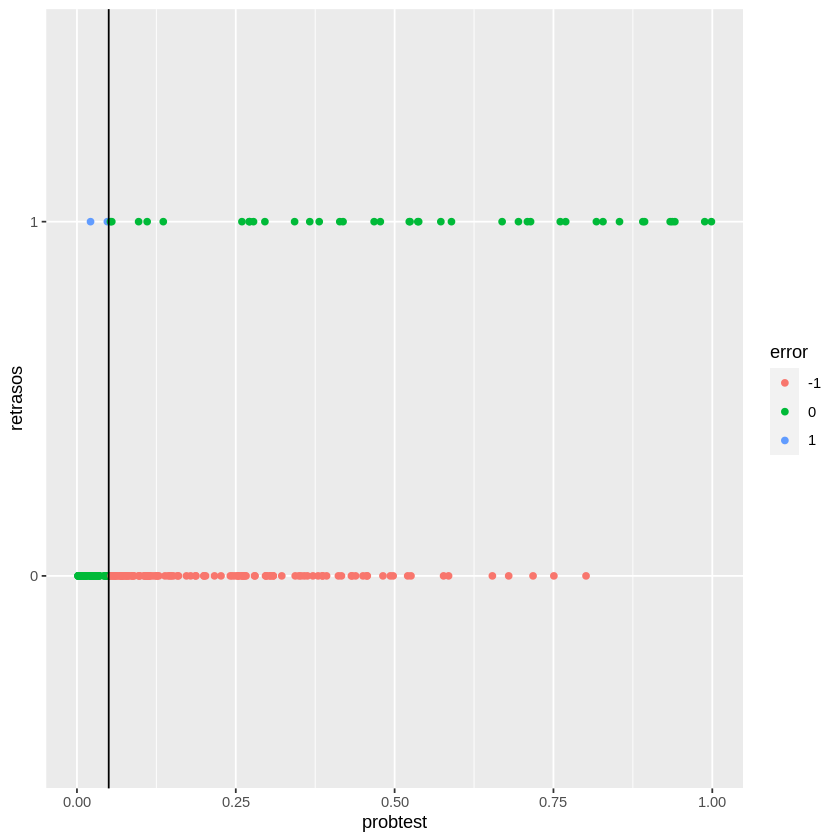

In [ ]:
corte<-0.05
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

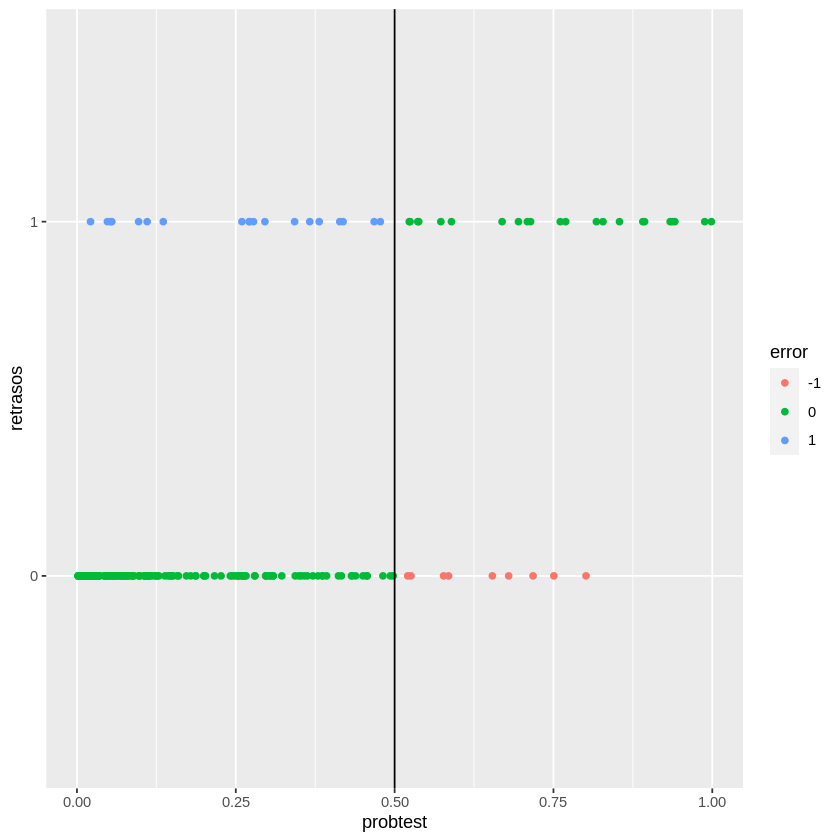

In [ ]:
corte<-0.5
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

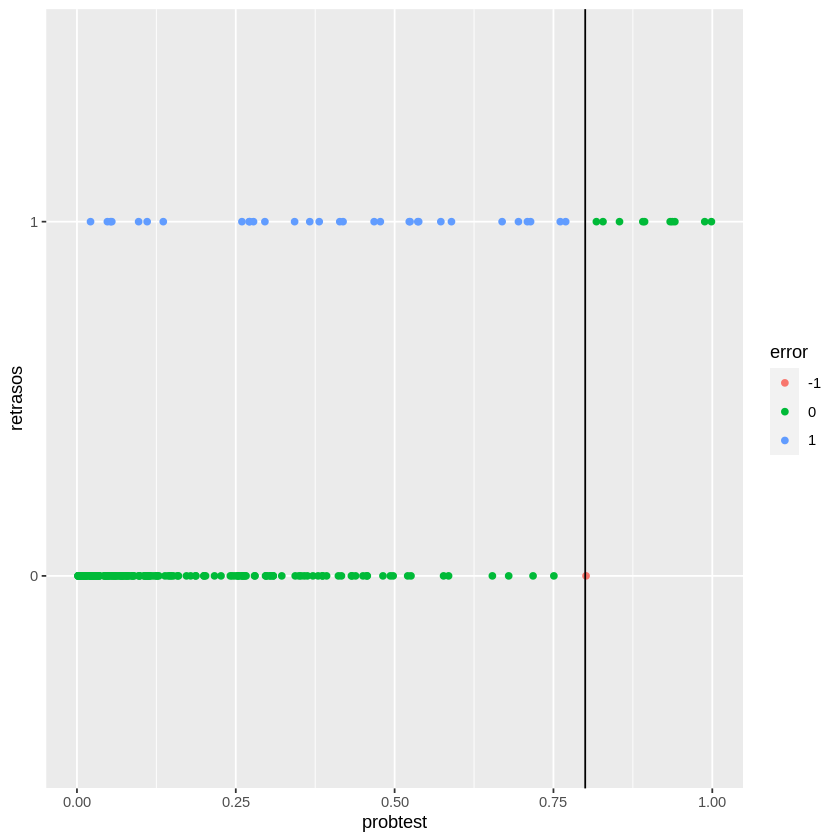

In [ ]:
corte<-0.8
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

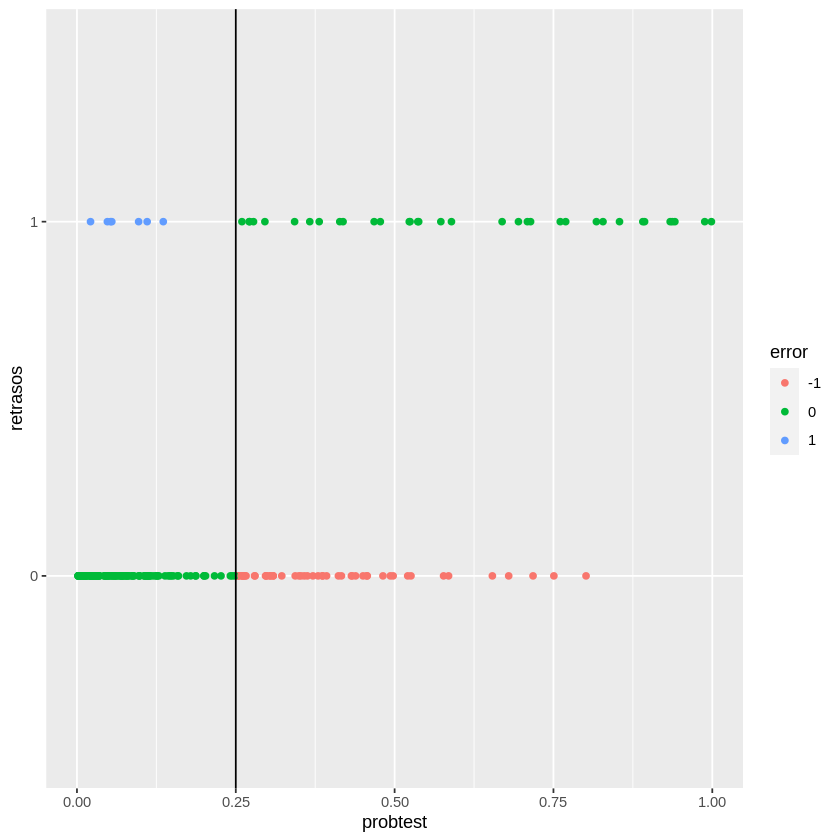

In [ ]:
corte<-0.25
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

In [ ]:
#crear objeto de predicciones
pr<-prediction(probtest,cartera.test$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")

[1] 0.8431651

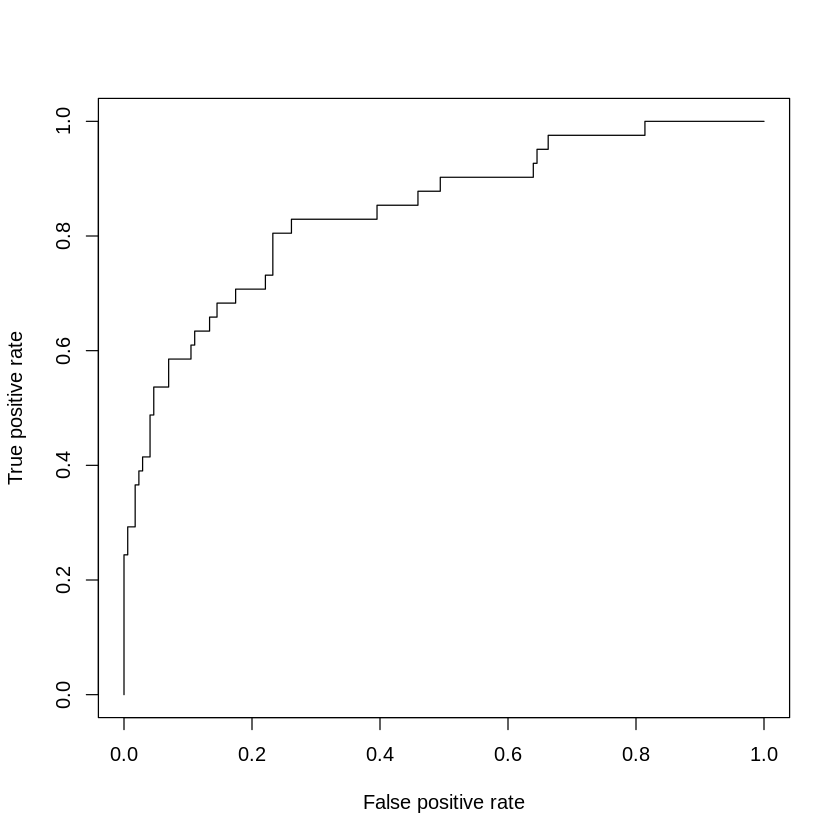

In [ ]:
#grafico de la curva
plot(curvaROC)
#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

El area bajo la curva es de 84.3%, lo cual está bien por encima del 50% de una predicción al azar.

•	La curva ROC ranquea todos las empresas desde el que tiene la probabilidad más alta de rechazo hasta la más baja (equivale a variar el umbral desde alto hasta bajo). Comenzando en el origen, mapea todos las empresas en orden descendiente de probabilidad (desde el “mejor” hasta el “peor”). Un clasificador perfecto, con exactitud 100%, primero predeciría correctamente todos los positivos, y luego predeciría correctamente todos los negativos; es decir, la curva iría recto hasta el punto (0,1), y luego cambiaría y sería horizontal hasta el punto (1,1). Esto, por supuesto, no es posible en la práctica, y los “pasos” en la curva reflejan los errores ocasionales que el modelo comete. Un buen modelo cometería pocos errores positivos para los mejores clientes y pocos eroreres negativos para los peores.

•	Es importante observar que un modelo que simplemente adivina al azar, tendrá como curva ROC una línea de 45 grados. Tal modelo tendría la misma probabilidad de hacer una predicción correcta que una incorrecta, sin importar si el cliente tiene una alta o baja probabilidad predecida.

•	En este caso el AUC es 84.3% el cual es un buen resultado. El AUC indica la proporción de parejas concordantes en los datos; en este caso el porcentaje de parejas concordantes es aproximadamente 84.3%. Las parejas concordantes son aquellas parejas de casos positivo y negativo en el dataset para las cuales el modelo de Regresión logística puede clasificarlos correctamente.

•	En el dataset de prueba, tenemos 41 positivos (empresas rechazadas) y 172 negativos (empresas sin rechazo); el número total de parejas (positivos y negativos) es 41 x 172 = 7052, de los cuales 84.3% (== 5945) tienen unos parámetros del modelo de Regresión Logística que pueden clasificarlos correctamente.


La curva COR muestra que para lograr un 80% de exhaustividad (tomar acciones sobre el 80% de los incumplidos), tendríamos que aceptar casi un 25% de falsos positivos (en lenguaje de negocios, tendríamos que “tocar o incomodar” al 25% de clientes que van a ser cumplidos)

De hecho, esos valores exactos son 23.83% y 80.48%. La tabla completa puede obtenerse de la siguiente manera:

In [ ]:
fprs<-unlist(curvaROC@x.values)
tprs<-unlist(curvaROC@y.values)
tablaCOR<-as.data.frame(cbind(fprs,tprs))
tablaCOR[70:90,]

,fprs,tprs
,<dbl>,<dbl>
70,0.2267442,0.7317073
71,0.2325581,0.7317073
72,0.2325581,0.7560976
73,0.2325581,0.7804878
74,0.2325581,0.8048780
75,0.2383721,0.8048780
76,0.2441860,0.8048780
77,0.2500000,0.8048780
78,0.2558140,0.8048780


## Evaluación financiera

Los valores de capacidad predictiva (y de error) deben ser vistos a la luz del negocio. Eso significa, usualmente, traducirlos en términos de costo/beneficio.

Ahi suele ser clave trabajar para maximizar la ganancia.

Para ello es importante definir los beneficios que nos trae un acierto y las pérdidas que nos genera un error.

Supongamos que un acierto nos permite ganancias (a 1 año) de 500 (mil pesos) y en cambio un fracaso nos hace perder un primer negocio de aproximadamente 100 (mil pesos). Vamos a suponer que el porcentaje de éxitos posibles es similar al de la base de datos completa.

Podemos crear una base de precisiones y exhaustividades que, basadas en la ecuación vista en clase, nos permitan calcular ganancias para diferentes puntos de corte:

In [ ]:
#guardar las exhaustividades y puntos de corte
tablafinan<-performance(pr,measure="rec")
cutoffs<-unlist(tablafinan@x.values)
recalls<-unlist(tablafinan@y.values)

In [ ]:
#guardar las precisiones
tablafina2<-performance(pr,measure="prec")
precisions<-unlist(tablafina2@y.values)

In [ ]:
#guardar f scores
tablafina3<-performance(pr,measure="f")
fscores<-unlist(tablafina3@y.values)

In [ ]:
#crear la tabla conjunta
tablacruce<-as.data.frame(cbind(cutoffs,precisions,recalls,fscores))
tablacruce

,cutoffs,precisions,recalls,fscores
,<dbl>,<dbl>,<dbl>,<dbl>
,Inf,NaN,0.00000000,NaN
96,0.9986011,1.0000000,0.02439024,0.04761905
203,0.9881200,1.0000000,0.04878049,0.09302326
88,0.9410898,1.0000000,0.07317073,0.13636364
24,0.9370073,1.0000000,0.09756098,0.17777778
120,0.9337317,1.0000000,0.12195122,0.21739130
26,0.8934212,1.0000000,0.14634146,0.25531915
156,0.8906942,1.0000000,0.17073171,0.29166667
177,0.8539614,1.0000000,0.19512195,0.32653061


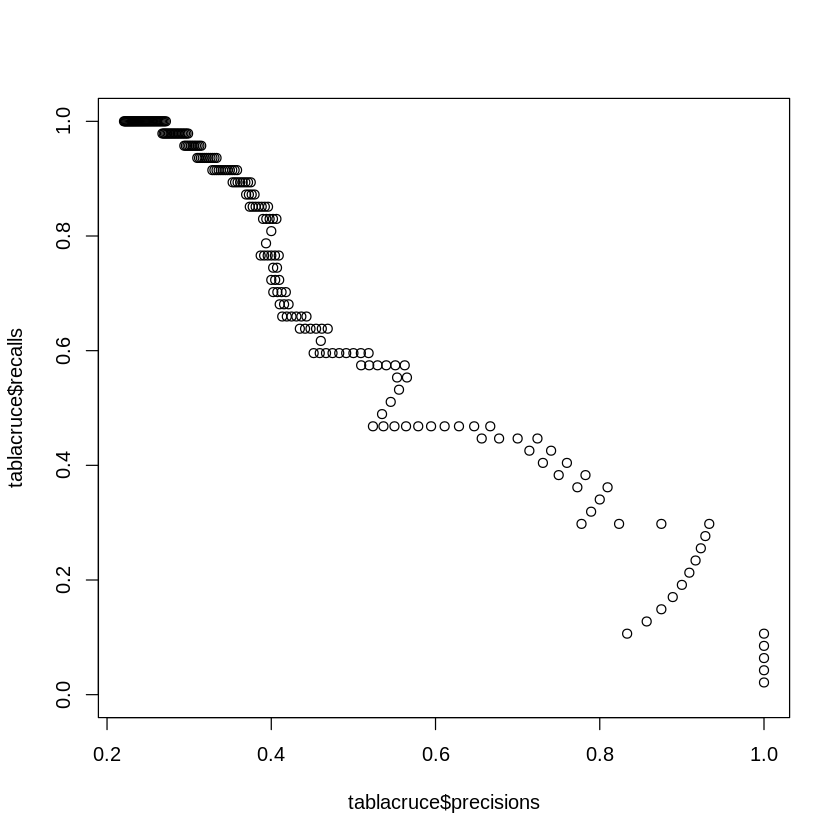

In [ ]:

#ver precisiones versus exhaustividad
plot(tablacruce$precisions,tablacruce$recalls)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


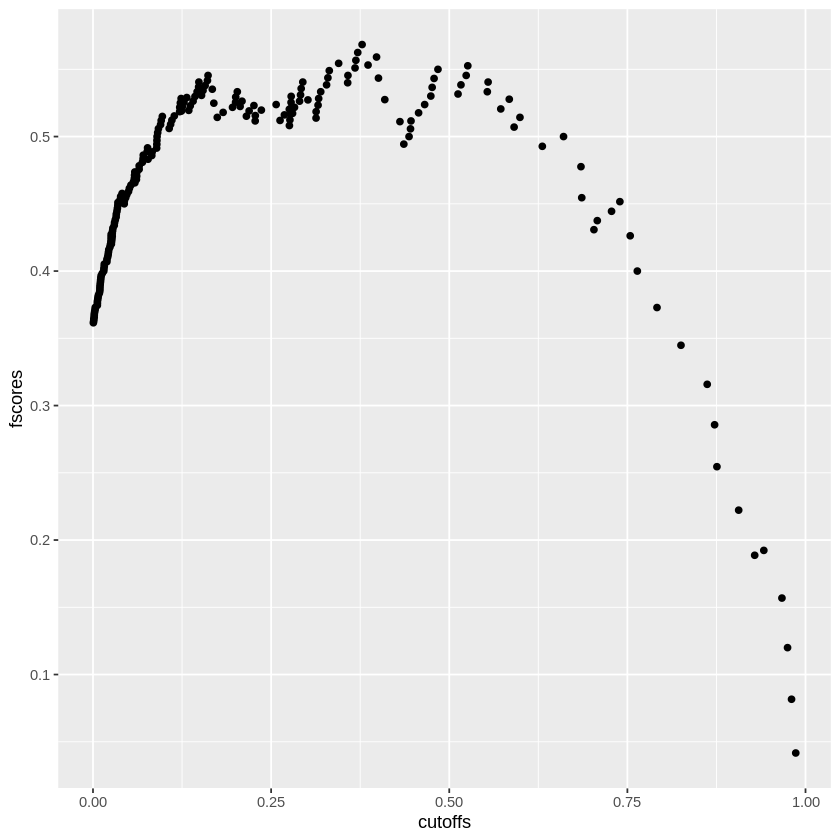

In [ ]:
#ver el cutoff que maximiza f score
ggplot(tablacruce, aes(cutoffs,fscores))+geom_point()


In [ ]:
#calcular las ganancias
tablacruce$wins<-prop.table(balance)[2]*recalls*(500-(100/precisions))

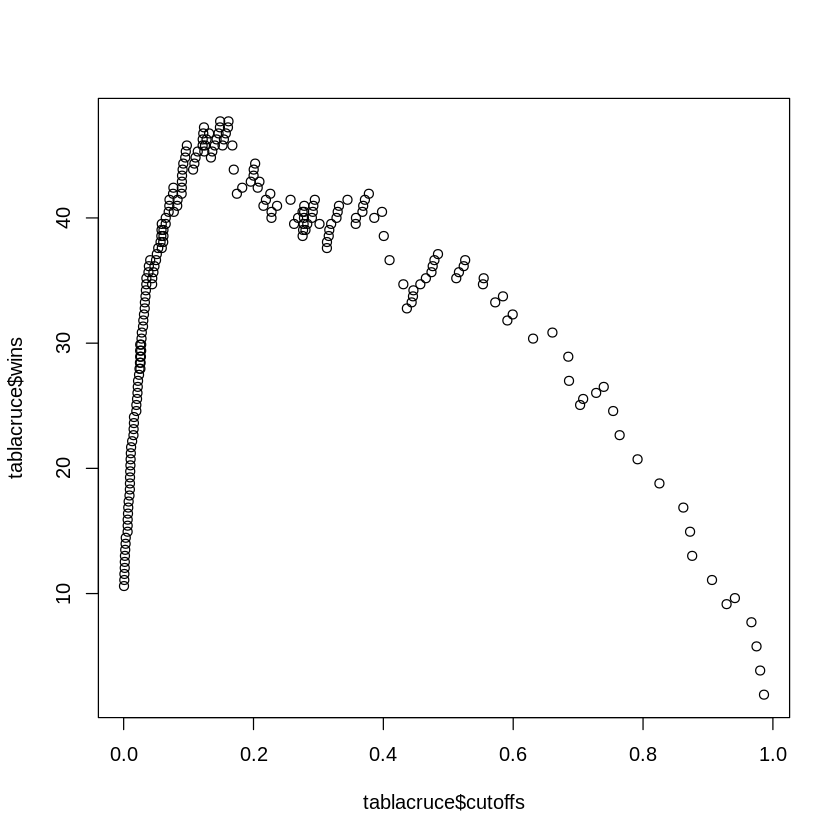

In [ ]:
#pintar las ganancias versus los cutoffs
plot(tablacruce$cutoffs,tablacruce$wins)

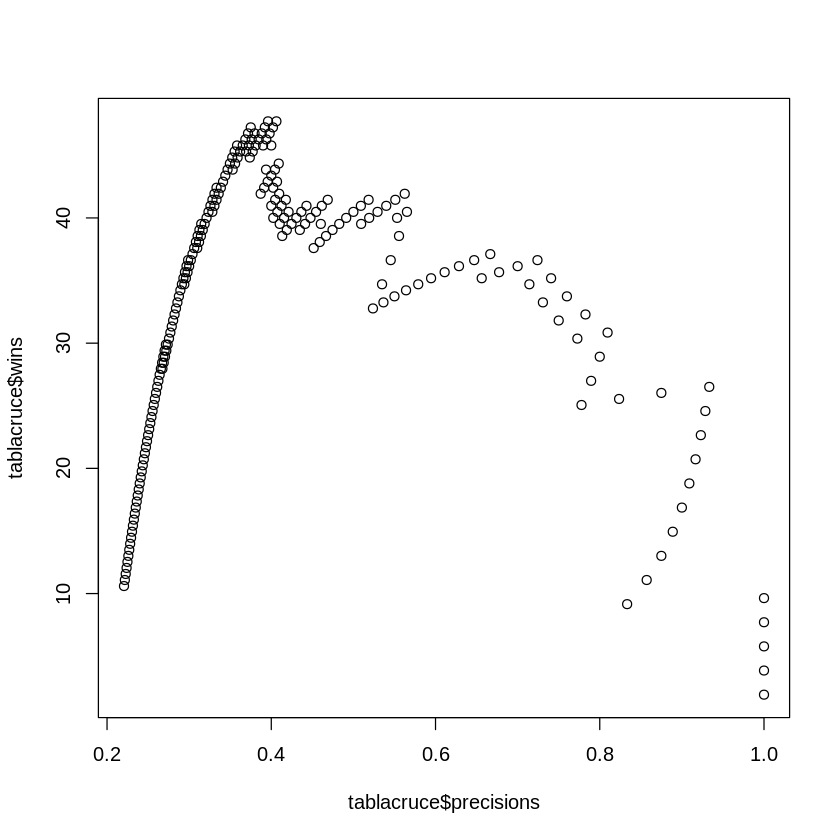

In [ ]:
#ver las ganancias frente a la precisión
plot(tablacruce$precisions,tablacruce$wins)

La primera gráfica nos muestra la relación inversa entre precisiones y exhaustividades.

La segunda gráfica nos presenta las ganancias (por cliente) contra los puntos de corte, de modo que podemos escoger un punto de corte ideal, el cual está cercano al 0.18, de hecho en la base de datos es 0.1614

La tercera gráfica nos muestra la relación de ganancias con precisones, donde es visible que no necesariamente la mayor precisión lleva a la mejor ganancia (por su baja exhaustividad)

Por supuesto, estos resultados dependen de la definición de ganancias y pérdidas. Si el costo de un cliente que incumple, por ejemplo, es del 70% frente a la ganancia que puede traer un cliente cumplido, entonces la precisión actual no es suficiente y debemos cambiar el punto de corte o buscar un balanceo de la base de datos que permita realizar mejores predicciones de incumplidos.

In [ ]:
tablaver<-subset(tablacruce, tablacruce$cutoffs>0.13 & tablacruce$cutoffs<0.22)
View(tablaver)

,cutoffs,precisions,recalls,fscores,wins
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
205,0.2191437,0.4047619,0.7234043,0.5190840,41.44941
192,0.2153136,0.4000000,0.7234043,0.5151515,40.96744
85,0.2091366,0.4069767,0.7446809,0.5263158,42.89532
146,0.2064775,0.4022989,0.7446809,0.5223881,42.41335
96,0.2025441,0.4090909,0.7659574,0.5333333,44.34122
60,0.2003074,0.4044944,0.7659574,0.5294118,43.85925
44,0.2001258,0.4000000,0.7659574,0.5255474,43.37728
100,0.1958257,0.3956044,0.7659574,0.5217391,42.89532
82,0.1826352,0.3913043,0.7659574,0.5179856,42.41335


## Balanceo

Una posibilidad para aprender más sobre los incumplimientos (1 en la base de datos) es generando muestras de tal modo que la base de entrenamiento tenga 50% de cada clase, y la base de validación el resto. Si hay bases de entrenamiento, validación y prueba, se deja la base de entrenamiento repartida por mitades entre los dos tipos de caso y la de prueba lo más similar a la original (en validación queda el resto). Vamos a crear divisiones basándonos en los incumplidos(nuestro éxito) de 20% para prueba, y 40%-40% para entrenamiento/validación.

Primero creamos la base de validación

In [ ]:
#Balanceo
##separamos ceros y unos
mayorcero<-subset(cartera,cartera$retrasos==0)
menoruno<-subset(cartera,cartera$retrasos==1)

In [ ]:
nrow(mayorcero)
nrow(menoruno)

[1] 659

[1] 193

In [ ]:
#en ambas bases el 20% es prueba
set.seed(24029114)

In [ ]:
#20% de ceros
sample <- sample.int(nrow(mayorcero), round(.2*nrow(mayorcero)))
mayorcero.test <- mayorcero[sample, ]
mayorcero.rest <- mayorcero[-sample, ]

In [ ]:
nrow(mayorcero.test)
nrow(mayorcero.rest)

[1] 132

[1] 527

In [ ]:
#20% de unos
sample <- sample.int(nrow(menoruno), round(.2*nrow(menoruno)))
menoruno.test <- menoruno[sample, ]
menoruno.rest <- menoruno[-sample, ]

In [ ]:
nrow(menoruno.test)
nrow(menoruno.rest)

[1] 39

[1] 154

In [ ]:
#fundo las dos
cart.test<-rbind(mayorcero.test,menoruno.test)
nrow(cart.test)

[1] 171

In [ ]:
table(cart.test$retrasos)


  0   1 
132  39 

En prueba nos quedaron 171 registros. Hagamos ahora entrenamiento y validación:

In [ ]:
sample <- sample.int(nrow(menoruno.rest), round(.5*nrow(menoruno.rest)))
menoruno.train <- menoruno.rest[sample, ]
menoruno.valid <- menoruno.rest[-sample, ]

In [ ]:
nrow(menoruno.train)
nrow(menoruno.valid)

[1] 77

[1] 77

In [ ]:
#pongo la misma cantidad de ceros y unos en entrenamiento:
sample <- sample.int(nrow(mayorcero.rest), nrow(menoruno.train))
mayorcero.train <- mayorcero.rest[sample, ]
mayorcero.valid <- mayorcero.rest[-sample, ]

In [ ]:
nrow(mayorcero.train)
nrow(mayorcero.valid)

[1] 77

[1] 450

In [ ]:
#creo entrenamiento y validación
cart.train<-rbind(mayorcero.train,menoruno.train)
cart.valid<-rbind(mayorcero.valid,menoruno.valid)

In [ ]:
#chequeo que todo va bien
table(cart.train$retrasos)
table(cart.valid$retrasos)
table(cart.test$retrasos)
prop.table(table(cart.train$retrasos))



 0  1 
77 77 


  0   1 
450  77 


  0   1 
132  39 


  0   1 
0.5 0.5 

In [ ]:
prop.table(table(cart.valid$retrasos))



        0         1 
0.8538899 0.1461101 

In [ ]:
prop.table(table(cart.test$retrasos))



        0         1 
0.7719298 0.2280702 

In [ ]:
prop.table(table(cartera$retrasos))


        0         1 
0.7734742 0.2265258 

Vemos que la base de entrenamiento queda 50%-50% de casos, la de validación 85%-15% y la de test 77.2% vs 22.8%, que es muy cercana a la original, 77.3% vs. 22.7%.

exploremos

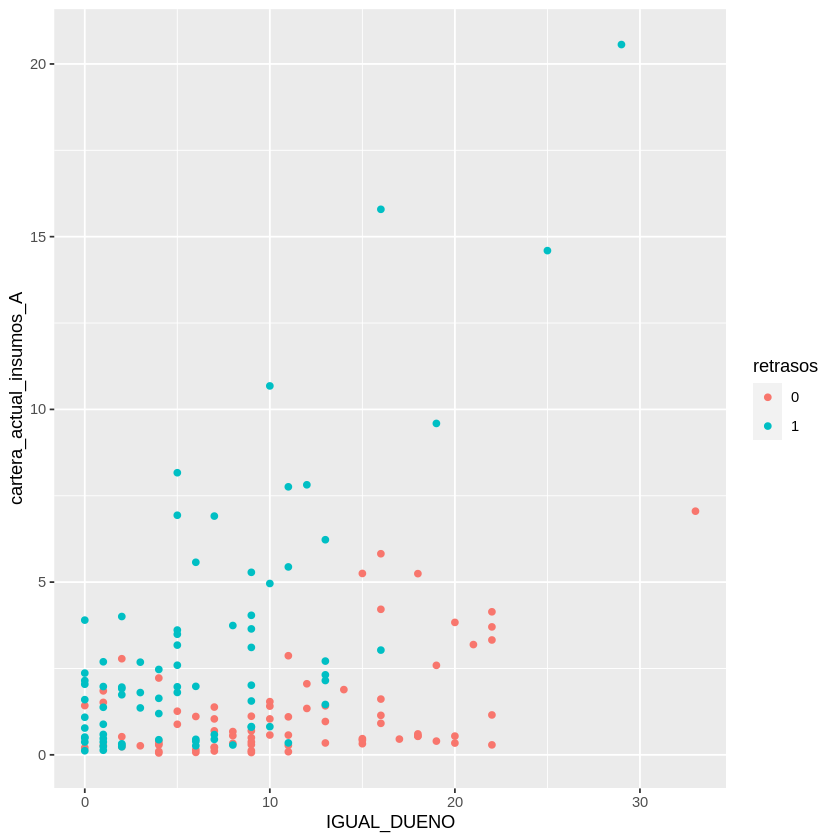

In [ ]:
ggplot(cart.train,aes(x=IGUAL_DUENO, y=cartera_actual_insumos_A,color=retrasos))+geom_point()

El gráfico es más visible que con la base de datos original, que tendría más puntos de cumplidos que de incumplidos.

Hagamos un modelo:

In [ ]:
modelo.balance<-glm(retrasos~.,family=binomial,cart.train)

In [ ]:
#trace=0 impide ver todos los detalles de la optimización stepwise
stepbalance<-step(modelo.balance, direction="both", trace=0)
summary(stepbalance)


Call:
glm(formula = retrasos ~ IGUAL_DUENO + PORC_PASIVOS_VENTA_ANUAL + 
    cartera_actual_insumos_A, family = binomial, data = cart.train)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.18637    0.48142  -0.387  0.69867    
IGUAL_DUENO              -0.25190    0.04963  -5.075 3.87e-07 ***
PORC_PASIVOS_VENTA_ANUAL  0.12025    0.03967   3.031  0.00244 ** 
cartera_actual_insumos_A  0.44227    0.16715   2.646  0.00815 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 213.49  on 153  degrees of freedom
Residual deviance: 128.12  on 150  degrees of freedom
AIC: 136.12

Number of Fisher Scoring iterations: 5


Note que las variables predictoras cambiaron. Tres se mantuvieron (pasivos, igual dueño y cartera A) pero 1 ya no quedó en el modelo (años dirección actual). Miremos los odds

In [ ]:
coeficientes2<-stepbalance$coefficients
odd_changeb<-exp(coeficientes2)
odd_changeb

(Intercept)              IGUAL_DUENO PORC_PASIVOS_VENTA_ANUAL 
               0.8299688                0.7773251                1.1277746 
cartera_actual_insumos_A 
               1.5562301

Cada año con el mismo dueño disminuyen el odd de ser incumplido al 82.9% , cada millón de cartera A aumenta ese odd en 55.6% y cada punto porcentual de pasivo aumenta el odd en 12.7%. Miremos sus métricas de desempeño en prueba:

In [ ]:
#crea el pronóstico en validación
probtest2<-predict(stepbalance,newdata = cart.test,type='response')
prontest2<-ifelse(probtest2 > 0.5,1,0)

In [ ]:
conftest2<-confusionMatrix(as.factor(prontest2),as.factor(cart.test$retrasos), positive = "1")
conftest2$table

          Reference
Prediction  0  1
         0 84  3
         1 48 36

In [ ]:
conftest2$byClass


Sensitivity          Specificity       Pos Pred Value 
           0.9230769            0.6363636            0.4285714 
      Neg Pred Value            Precision               Recall 
           0.9655172            0.4285714            0.9230769 
                  F1           Prevalence       Detection Rate 
           0.5853659            0.2280702            0.2105263 
Detection Prevalence    Balanced Accuracy 
           0.4912281            0.7797203

Nótese que la precisión baja (al 42.8%) pero la exhaustividad sube (al 92.3%). El F score, con punto de corte en 0.5 es de 58.5%.

Sin embargo las comparaciones no son muy viables dado que estamos usando bases de test diferentes. Y en cuanto a AUC?

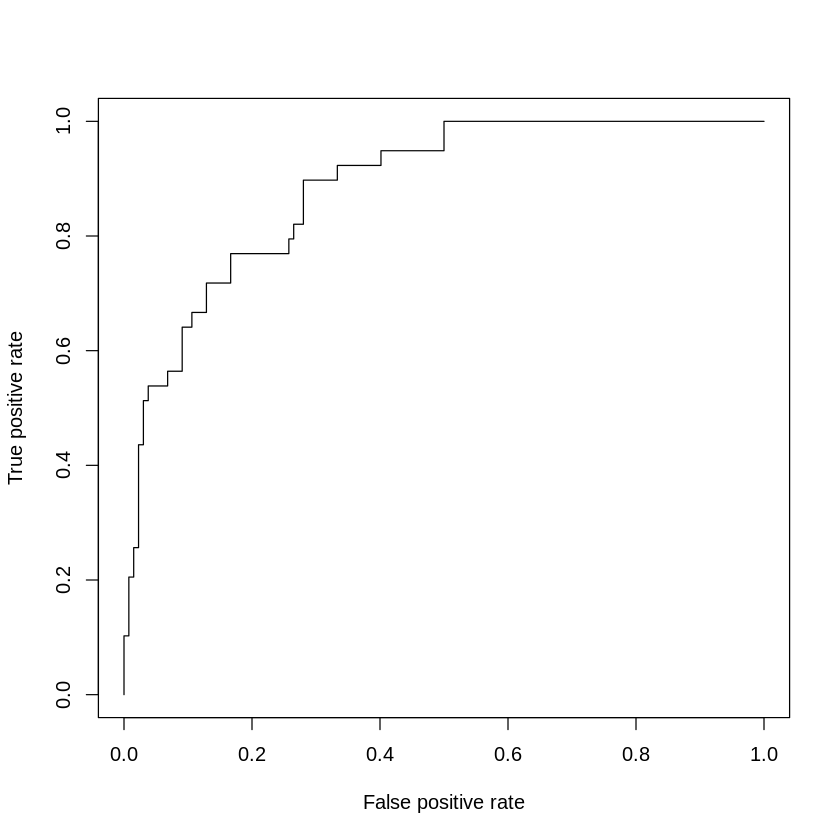

In [ ]:
#crear objeto de predicciones
pr2<-prediction(probtest2,cart.test$retrasos)
#creacion del objeto de la curva
curvaROC2<-performance(pr2,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC2)

In [ ]:
#calcular el AUC
auc2<-performance(pr2,measure = "auc")
auc2f <- auc2@y.values[[1]]
#ver el AUC
auc2f

[1] 0.8850039

Nuestro AUC ahora es del 88%, y ahora el modelo está sesgado en la búsqueda de incumplidos.

## Uso de **SMOTE**

In [ ]:
remotes::install_github("cran/DMwR")

curl     (5.0.2 -> 5.2.1 ) [CRAN]
zoo      (NA    -> 1.8-12) [CRAN]
xts      (NA    -> 0.13.2) [CRAN]
TTR      (NA    -> 0.24.4) [CRAN]
abind    (NA    -> 1.4-5 ) [CRAN]
quantmod (NA    -> 0.4.26) [CRAN]


Installing 6 packages: curl, zoo, xts, TTR, abind, quantmod

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmporV9Mc/remotes4051b0bbd69/cran-DMwR-6fd4f0c/DESCRIPTION’ ... OK
* preparing ‘DMwR’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘DMwR_0.4.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
table(cartera.train$retrasos)


  0   1 
487 152 

In [ ]:
library(DMwR)

#utilizar SMOTE para crear un nuevo conjunto de datos más equilibrado
new_df <- SMOTE(retrasos~., as.data.frame(cartera.train), perc.over = 200, perc.under = 200)

#ver la distribución de la variable de respuesta en el nuevo conjunto de datos
table(new_df$retrasos)


  0   1 
608 456 

In [ ]:
##Modelo
modelo.SMOTE<-glm(retrasos~.,family=binomial,new_df)
#trace=0 impide ver todos los detalles de la optimización stepwise
steplogit<-step(modelo.SMOTE, direction="both")
summary(steplogit)

Start:  AIC=981.23
retrasos ~ MESES + TIPO_ips + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + 
    VENTAS_MENS_PROMEDIO + PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + 
    cartera_actual_insumos_B + TIPOips

                           Df Deviance     AIC
- cartera_actual_insumos_B  1   955.45  979.45
<none>                          955.23  981.23
- TIPO_ips                  1   957.82  981.82
- MESES                     1   957.87  981.87
- VENTAS_MENS_PROMEDIO      1   958.82  982.82
- TIPOips                   4   968.36  986.36
- AGNOS_DIRECCION_ACTUAL    1   975.00  999.00
- PORC_PASIVOS_VENTA_ANUAL  1   978.94 1002.94
- cartera_actual_insumos_A  1  1013.01 1037.01
- IGUAL_DUENO               1  1064.85 1088.85

Step:  AIC=979.45
retrasos ~ MESES + TIPO_ips + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + 
    VENTAS_MENS_PROMEDIO + PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + 
    TIPOips

                           Df Deviance     AIC
<none>                          955.45  9


Call:
glm(formula = retrasos ~ MESES + TIPO_ips + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + 
    VENTAS_MENS_PROMEDIO + PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + 
    TIPOips, family = binomial, data = new_df)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.767114   0.515284  -3.429 0.000605 ***
MESES                     0.023515   0.014065   1.672 0.094559 .  
TIPO_ips                  0.442425   0.270819   1.634 0.102332    
IGUAL_DUENO              -0.239837   0.024857  -9.649  < 2e-16 ***
AGNOS_DIRECCION_ACTUAL   -0.080455   0.018478  -4.354 1.34e-05 ***
VENTAS_MENS_PROMEDIO     -0.008717   0.004534  -1.922 0.054559 .  
PORC_PASIVOS_VENTA_ANUAL  0.125860   0.016898   7.448 9.47e-14 ***
cartera_actual_insumos_A  0.553016   0.086523   6.392 1.64e-10 ***
TIPOips2                  0.266725   0.267683   0.996 0.319045    
TIPOips3                 -0.188319   0.527892  -0.357 0.721288    
TIPOips4                 -1.

In [ ]:
#crea el pronóstico en validación
probtest<-predict(steplogit,newdata = cartera.test,type='response')
prontest<-ifelse(probtest > 0.5,1,0)
conftest<-confusionMatrix(as.factor(prontest),cartera.test$retrasos, positive = "1")
conftest$table
conftest$byClass

          Reference
Prediction   0   1
         0 131  10
         1  41  31

Sensitivity          Specificity       Pos Pred Value 
           0.7560976            0.7616279            0.4305556 
      Neg Pred Value            Precision               Recall 
           0.9290780            0.4305556            0.7560976 
                  F1           Prevalence       Detection Rate 
           0.5486726            0.1924883            0.1455399 
Detection Prevalence    Balanced Accuracy 
           0.3380282            0.7588627

En este libro de notas hemos realizado modelos de regresión logística binaria para clasificación, y hemos podido revisar aspectos básicos de evaluación de dichos modelos (incluyendo la parte financiera) y la posibilidad de generar un sesgo de balance para aprender más de una clase que nos interesa más.